# Imports

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import Image
import matplotlib.dates as md

from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import datetime

import os
from glob import glob

# Global Variables

In [2]:
directoriesList = ["C:/Users/T-Gamer/Documents/Projetos - Git/FinalCourseAssignment/Dataset/20171203/"]
filesDelimiter  = '\t'
window_size     = 5

pothole_output   = 1
speedbump_output = 2
default_output   = 0

# Functions 

In [176]:
def getFilesFromDirectories(directories, filetype = "csv", pattern = "*."):
    files     = []
    _pattern   = pattern + filetype
    
    try:
        for directory in directories:
            for dir,_,_ in os.walk(directory):
                files.extend(glob(os.path.join(dir, _pattern)))
    except:
        print("\Error to get files from directories. Do you do \"import os\" and \"from glob import glob\" ?")
        
    return files


def windowNormalization (serie, window_size):
    elems     = np.zeros(len(serie))
    pos_begin = pos_end = 0
    media     = std = 0.0
    count     = 0
    
    while count <= (len(elems) - window_size):
        
        #Is the process at the end?
        if (count + window_size == len(elems)):
            aux = count - 1
            while count < len(elems):
                elems[count] = elems[aux]
                count +=1
            break
            
        pos_end = pos_begin + window_size
        media   = np.mean(serie[pos_begin:pos_end])
        std     = np.std (serie[pos_begin:pos_end])
        
        elems[pos_begin] += np.sqrt((serie[pos_end] - media)**2/std)

        count     +=1
        pos_begin +=1
    
    return elems.tolist()
    
    
def fullNormalization(serie):
    media = np.mean(serie)
    std   = np.std(serie)
    
    return np.sqrt((serie - media)**2/std)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

def strOp2datetime(_datetimestr = "", _format = "", _milliseconds = 0, _seconds = 0, _minutes = 0, _hours = 0):
    
    #first case: Just sum values with current datetime
    if _datetimestr is "" and _format is "":
        current_date = datetime.datetime.strptime(datetime.datetime.today().strftime('%Y %m %d %H %M %S %f'), "%Y %m %d %H %M %S %f")
        current_date = current_date + datetime.timedelta(hours = _hours, minutes = _minutes, seconds = _seconds, milliseconds = _milliseconds)
        return str(current_date)
    
    #second case: sum values with given datetime
    if _datetimestr is not "" and _format is not "":
        try:
            current_date = datetime.datetime.strptime(_datetimestr, _format)
            current_date = current_date + datetime.timedelta(hours = _hours, minutes = _minutes, seconds = _seconds, milliseconds = _milliseconds)
            return str(current_date)
        except:
            print('Are you sure you give the right format?')
            return None
        
    print('This method have two possible cases.\nFirst: _datetimestr and _format not filled.\nSecond:_datetimestr and _format filled\n')
    return None

def plotTooltipBokeh(axisSensor, dataframe, dataframe_pothole,dataframe_speedBump, _color = 'red', pos_df_pothole = 15, pos_df_speedBump = 18):
    from bokeh.models   import HoverTool, BoxZoomTool,UndoTool, SaveTool
    from bokeh.charts   import Line
    from bokeh.plotting import output_notebook, show
    from bokeh.models   import  BasicTickFormatter

    output_notebook()
    
    data      = {axisSensor: dataframe[axisSensor].tolist()}
    index     = dataframe['timestamp'].tolist()
    dataframe = pd.DataFrame(data=data, index=index)
    dataframe = dataframe.assign(x=dataframe.index)
    columns   = dataframe.columns.values.tolist()
    columns.remove('x')

    dataframe_pothole['Pothole occurrence']     = pos_df_pothole
    dataframe_speedBump['SpeedBump occurrence'] = pos_df_speedBump

    hover = HoverTool(
            tooltips=[
                ("lineNumberFile", "$index"),
                ("Timestamp, accelerometer", "($x{int}, $y)")
            ]
        )

    # Sensor's Data
    p = Line(data = dataframe, x ='x', legend = False,
             title="AXIS " + axisSensor[-1] + " - ACCELEROMETER",
             xlabel='Timestamp', ylabel='m/s^2',
             width=950, height=400, color=_color,
             notebook=True, tools = [hover,BoxZoomTool(),UndoTool(),SaveTool()])

    p.y_range.end   = 25
    p.x_range.start = dataframe['x'].iloc[0] - 10
    p.x_range.end   = dataframe['x'].iloc[-1]+ 1000

    # Pothole
    p.circle(dataframe_pothole['timestamp'].tolist(), dataframe_pothole['Pothole occurrence'].tolist(),fill_color="white",size=8)

    # SpeedBump
    p.inverted_triangle(dataframe_speedBump['timestamp'].tolist(), dataframe_speedBump['SpeedBump occurrence'].tolist(),size=8, color="#DE2D26")

    p.xaxis.formatter=BasicTickFormatter(use_scientific=False)
    show(p)

# Code

In [4]:
# Get Paths from specific file
speedbumpPath = getFilesFromDirectories(directoriesList, pattern = "SpeedBump_InicioAsfaltoVelhoAteRodovia*.")[0]
potholePath   = getFilesFromDirectories(directoriesList, pattern = "Pothole_InicioAsfaltoVelhoAteRodovia*.")[0]
generalPath   = getFilesFromDirectories(directoriesList, pattern = "InicioAsfaltoVelhoAteRodovia*.")[0]

In [5]:
# Reading csv files
df_general    = pd.read_csv(generalPath, delimiter   = filesDelimiter)
df_pothole    = pd.read_csv(potholePath, delimiter   = filesDelimiter)
df_speedbump  = pd.read_csv(speedbumpPath, delimiter = filesDelimiter)

In [12]:
# New data columns from df_general normalization
df_general['accelerometer_normX'] = windowNormalization(df_general['accelerometer_X'], window_size)
df_general['accelerometer_normY'] = windowNormalization(df_general['accelerometer_Y'], window_size)
df_general['accelerometer_normZ'] = windowNormalization(df_general['accelerometer_Z'], window_size)

In [6]:
# Build output column values
df_general.loc[df_general['timestamp'].isin(list(df_pothole['timestamp'])), 'output']   = pothole_output
df_general.loc[df_general['timestamp'].isin(list(df_speedbump['timestamp'])), 'output'] = speedbump_output

df_general['output'] = df_general['output'].fillna(default_output)

In [21]:
# Split accelerometer_X column data into training and test
X_train, X_test, XO_train, XO_test = train_test_split(df_general['accelerometer_X'], df_general['output'], test_size=0.25, random_state=42)

print(len(XO_train[XO_train == 0]))
print(len(XO_train[XO_train == 1]))
print(len(XO_train[XO_train == 2]))

In [103]:
# Add the values from "timestamp" column in the current datetime and a new datetime column is created to be used as index
timestamp_values = list(df_general['timestamp'])

datetime_values = []
for value in timestamp_values:
    result = strOp2datetime(_milliseconds = int(value))
    if result is not None:
        datetime_values.append(result)

df_general['datetime'] = datetime_values
df_general.set_index('datetime')

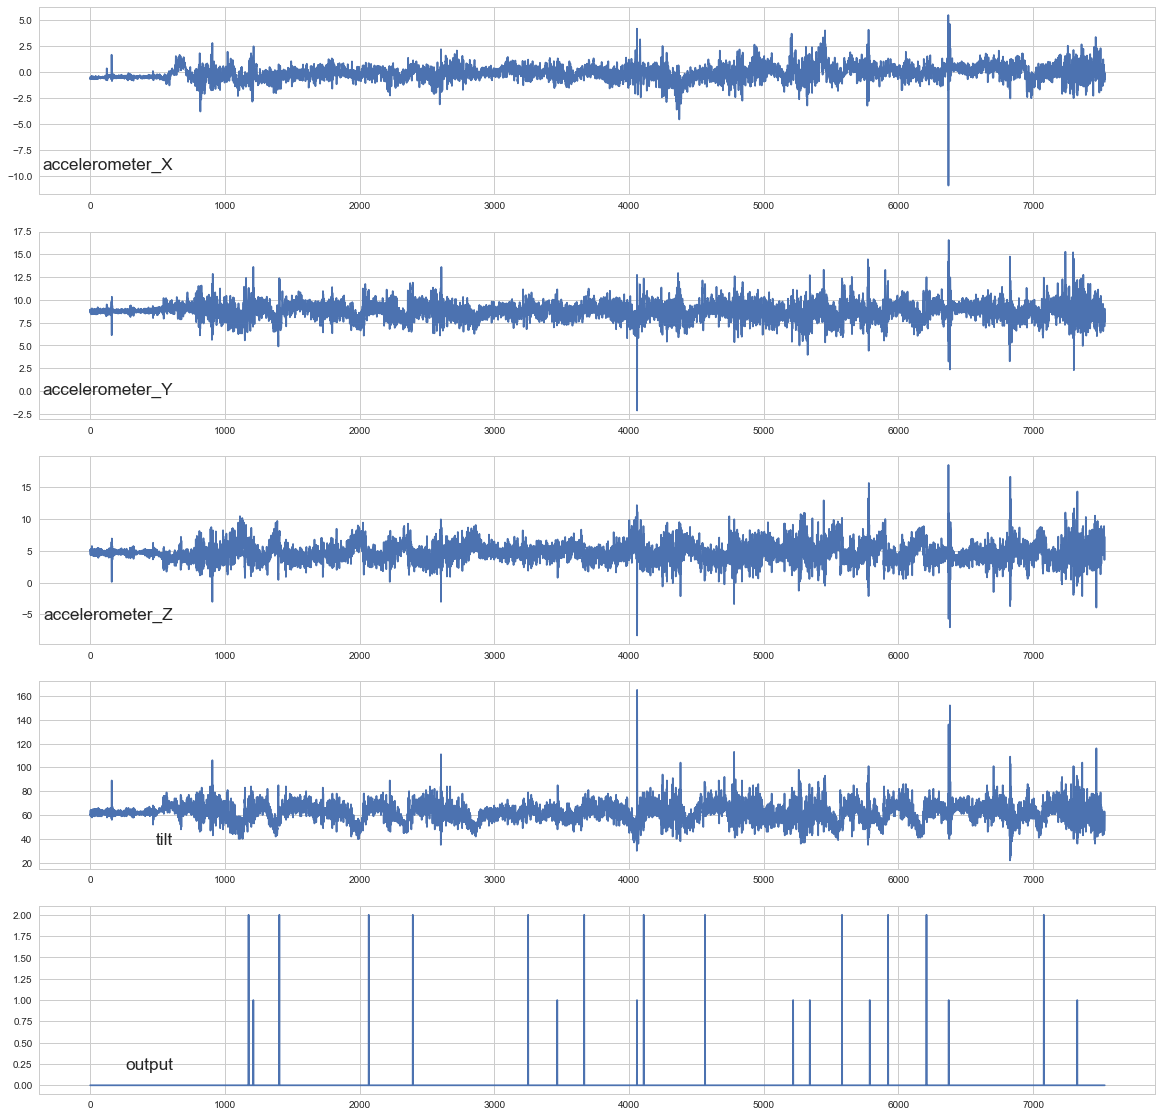

In [129]:
values = df_general.values

# specify columns to plot
groups = [0, 1, 2, 5, 8]
i = 1
# plot each column
plt.figure(figsize=(20,20))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df_general.columns[group], x =0.12,y=0.1, size = 'xx-large', loc='right')
    i += 1
plt.show()

In [183]:
values = df_general.filter(['accelerometer_X','accelerometer_Y','accelerometer_Z','output'], axis=1).values
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 60, 1)

# drop columns we don't want to predict
reframed.drop(['var1(t)', 'var2(t)', 'var3(t)'], axis=1, inplace=True)
print(reframed.head())

    var1(t-60)  var2(t-60)  var3(t-60)  var4(t-60)  var1(t-59)  var2(t-59)  \
60    0.628776    0.590903    0.498530         0.0    0.623668    0.587306   
61    0.623668    0.587306    0.502896         0.0    0.637823    0.572401   
62    0.637823    0.572401    0.473046         0.0    0.636947    0.592959   
63    0.636947    0.592959    0.474918         0.0    0.624836    0.585121   
64    0.624836    0.585121    0.504767         0.0    0.634758    0.573815   

    var3(t-59)  var4(t-59)  var1(t-58)  var2(t-58)   ...     var4(t-3)  \
60    0.502896         0.0    0.637823    0.572401   ...           0.0   
61    0.473046         0.0    0.636947    0.592959   ...           0.0   
62    0.474918         0.0    0.624836    0.585121   ...           0.0   
63    0.504767         0.0    0.634758    0.573815   ...           0.0   
64    0.482759         0.0    0.637823    0.587434   ...           0.0   

    var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var1(t-1)  var2(t-1)  \
60   0.636510 

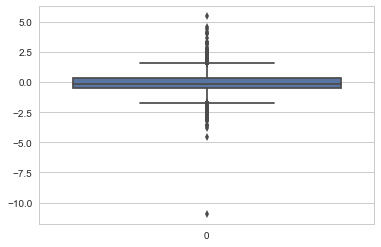

In [8]:
# Graph mode Outliers detection 
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
#iris = sns.load_dataset("iris")
sns.boxplot(data=df_general['accelerometer_X']);

In [114]:
def outliers_iqr(serie, threshold = 2, debug = False, should_delete_outliers = False):
    quartile_1, quartile_3 = np.percentile(serie, [10, 90])

    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * threshold)
    upper_bound = quartile_3 + (iqr * threshold)
    
    if debug:
        print('quartile_1: ')
        print(quartile_1)
        print('quartile_3: ')
        print(quartile_3)
        print('lower_bound:')
        print(lower_bound)
        print('upper_bound:')
        print(upper_bound)
        
    list_outliers_index = list(np.where((serie > upper_bound) | (serie < lower_bound)))
    
    if should_delete_outliers:
        serie = serie.drop(serie.index[list_outliers_index], inplace = True)
        
    return list_outliers_index

In [89]:
a = outliers_iqr(df_general['accelerometer_Z'])
df_new = df_general
a = outliers_iqr(df_new['accelerometer_Z'], should_delete_outliers = False)
print(a)
print(len(df_new['accelerometer_Z']))
print(len(df_general))

quartile_1: 
2.8874955
quartile_3: 
6.7303066
lower_bound:
-4.7981267
upper_bound:
14.4159288


In [14]:
plotTooltipBokeh('accelerometer_Y', df_general, df_pothole,df_speedbump,'red',20,22)

Loading BokehJS ...

C:\Program Files\Anaconda3\lib\site-packages\bokeh\core\json_encoder.py:73: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if pd and isinstance(obj, pd.tslib.Timestamp):


[]

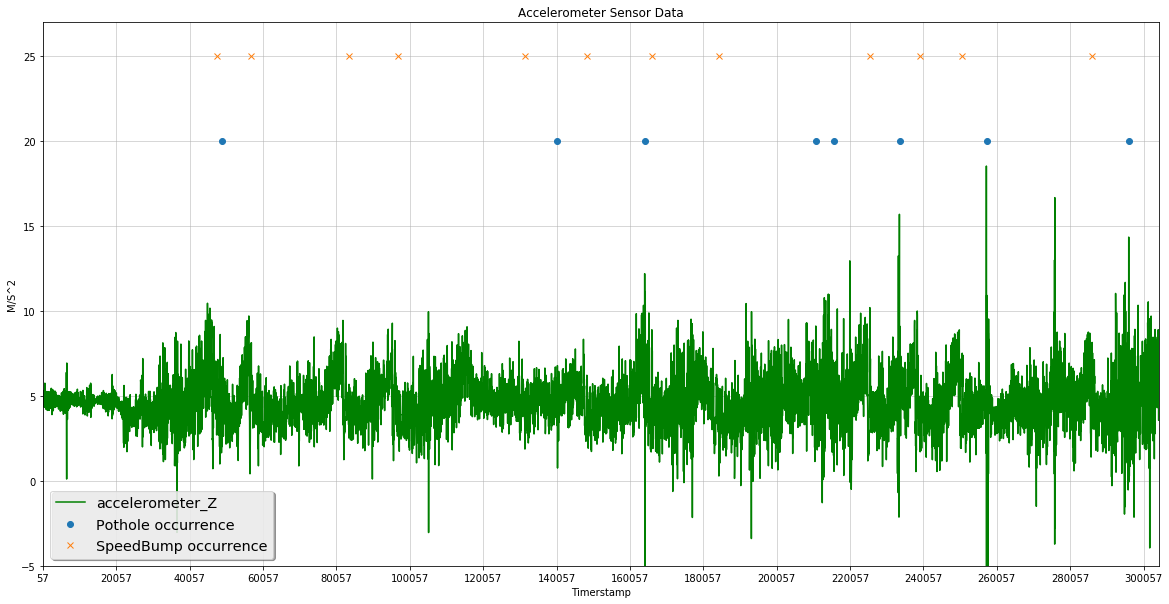

In [50]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(df_general['timestamp'],df_general['accelerometer_Z'], 'g-')

df_pothole['Pothole occurrence'] = 20
df_speedbump['SpeedBump occurrence'] = 25
ax.plot(df_pothole['timestamp'],df_pothole['Pothole occurrence'], 'o')
ax.plot(df_speedbump['timestamp'],df_speedbump['SpeedBump occurrence'], 'x')

#ax.legend(loc='lower left',bbox_to_anchor=(1.1, 0.5),fontsize='x-large')
ax.legend(loc='lower left',fontsize='x-large',shadow = bool)
ax.set_ylabel('M/S^2')
ax.set_xlabel('Timerstamp')
ax.set_title('Accelerometer Sensor Data')
ax.grid(True,linewidth=0.5,linestyle='-')
ax.set_xticks(np.arange(df_general['timestamp'].min(),df_general['timestamp'].max(), 20000))
ax.set_xlim([df_general['timestamp'].min(), df_general['timestamp'].max()])
ax.set_ylim([-5,27])
ax.plot()